#### import libabry

In [40]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import torchvision
from torchvision import transforms

torch.set_printoptions(linewidth=120)

import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix
from plotcm import plot_confusion_matrix

#### ETL

In [2]:
train_set = torchvision.datasets.FashionMNIST(
root="./data/FashionMNIST"
    , train=True
    , download=True
    , transform=transforms.Compose([transforms.ToTensor()])
)
batch_size = 100
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

##### data

In [3]:
print("training dataset length:", len(train_set))
print("training dataset shape:", train_set.data.shape)

training dataset length: 60000
training dataset shape: torch.Size([60000, 28, 28])


#### labels

In [4]:
print("training dataset length:", len(train_set.targets))
print("training dataset shape:", train_set.targets.shape)
train_set.targets.bincount()

training dataset length: 60000
training dataset shape: torch.Size([60000])


tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

##### visualization

In [5]:
image, label = next(iter(train_set))

In [6]:
image.shape

torch.Size([1, 28, 28])

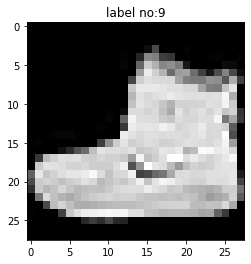

In [7]:
plt.imshow(image.squeeze(), cmap = "gray")
plt.title("label no:"+str(label))
plt.show()

#### batch

In [8]:
batch = next(iter(train_loader))
images, labels = batch
print("images shape", images.shape)
print("labels shape", labels.shape)

images shape torch.Size([100, 1, 28, 28])
labels shape torch.Size([100])


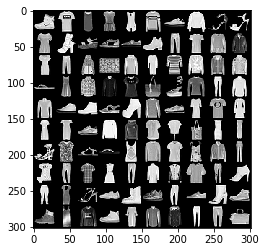

[[9 0 0 3 0 2 7 2 5 5]
 [0 9 5 5 7 9 1 0 6 4]
 [3 1 4 8 4 3 0 2 4 4]
 [5 3 6 6 0 8 5 2 1 6]
 [6 7 9 5 9 2 7 3 0 3]
 [3 3 7 2 2 6 6 8 3 3]
 [5 0 5 5 0 2 0 0 4 1]
 [3 1 6 3 1 4 4 6 1 9]
 [1 3 5 7 9 7 1 7 9 9]
 [9 3 2 9 3 6 4 1 1 8]]


In [9]:
grid = torchvision.utils.make_grid(images, nrow=10)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.show()
print(np.array(np.split(labels.numpy(), batch_size/10)))

#### Model

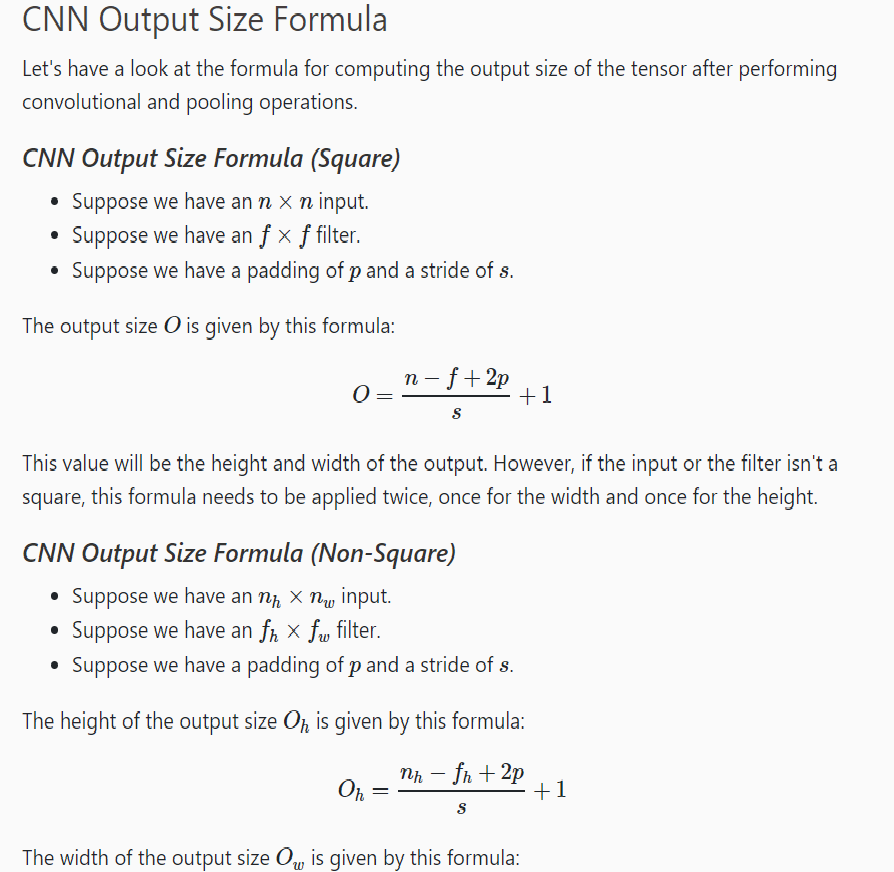

In [10]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120, bias =True)
        self.fc2 = nn.Linear(in_features=120, out_features=60, bias =True)
        self.out = nn.Linear(in_features=60, out_features=10, bias =True)
    
    def forward(self, t):
        # (1) input layer
        # t = t
        # (2) hiden conv layer
        t = self.conv1(F.relu(t))
        t = F.max_pool2d(t, kernel_size=(2,2), stride=(2,2))
        # (3) hiden conv layer
        t = self.conv2(F.relu(t))
        t = F.max_pool2d(t, kernel_size=(2,2), stride=(2,2))
        # (4) hidden liner layer
        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        # (5) hidden liner layer
        t = F.relu(self.fc2(t))
        # (6) output layer
        t = self.out(t)   
        return t
    
    #if we want a default message to be shown, while printing the object of this class
    #def __repr__(self):
    #    return "default message"
        

#### training loop

In [11]:
num_training_items = len(train_set)
num_epoch = 10
batch_size = 100
learning_rate = 0.01
loss_curve = list()
accuracy_curve = list()

network = Network()
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

batch = next(iter(train_loader))
optimizer = optim.Adam(network.parameters(), lr=learning_rate)

for e in range(num_epoch):
    total_loss = 0
    total_correct = 0
    for batch in train_loader:
        images, labels = batch
        preds = network(images)
        loss = F.cross_entropy(preds, labels)
        num_correct = F.softmax(preds, dim=1).argmax(dim=1).eq(labels).sum().item()
        
        # pytorch accumulate gradient. hence let's inetialize to zero after each batch
        optimizer.zero_grad()
        # calculating gradients
        loss.backward()
        # updating weights
        optimizer.step()
        
        total_loss += loss.item()
        total_correct += num_correct
        

    print("epoch = {}, total loss = {}, total correct items = {}".format(e+1, total_loss, total_correct))
    loss_curve.append(total_loss)
    accuracy_curve.append(total_correct/num_training_items)

epoch = 1, total loss = 314.8611658960581, total correct items = 48194
epoch = 2, total loss = 216.14742377400398, total correct items = 51995
epoch = 3, total loss = 201.3291383832693, total correct items = 52594
epoch = 4, total loss = 191.20261126756668, total correct items = 52946
epoch = 5, total loss = 188.56597819179296, total correct items = 53058
epoch = 6, total loss = 188.9600641578436, total correct items = 53075
epoch = 7, total loss = 189.3544051349163, total correct items = 53028
epoch = 8, total loss = 187.38788603246212, total correct items = 53168
epoch = 9, total loss = 177.1459911763668, total correct items = 53449
epoch = 10, total loss = 175.45527840405703, total correct items = 53601


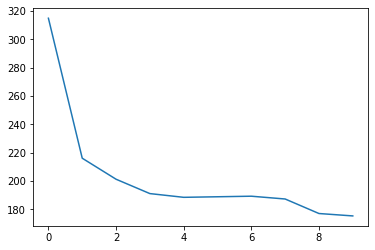

In [12]:
plt.plot(loss_curve)
plt.show()

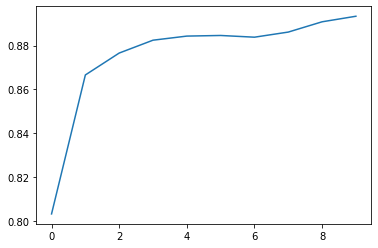

In [13]:
plt.plot(accuracy_curve)
plt.show()

#### confusion matrix

In [27]:
@torch.no_grad()
def get_all_preds(model, loader):
    all_preds = torch.tensor([])
    for batch in loader:
        images, labels = batch
        preds = model(images)
        all_preds = torch.cat((all_preds, preds), dim = 0)
    return all_preds

In [15]:
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)
train_preds.shape

In [30]:
F.softmax(train_preds, dim=1).argmax(dim=1).eq(train_set.targets).sum().item()

53742

In [33]:
stacked = torch.stack((train_set.targets, F.softmax(train_preds, dim=1).argmax(dim=1)), dim=1)
stacked.shape

torch.Size([60000, 2])

In [44]:
cmt = torch.zeros(10,10, dtype=torch.int64)
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [45]:
cmt = confusion_matrix(train_set.targets, F.softmax(train_preds, dim=1).argmax(dim=1))

Confusion matrix, without normalization
[[5322    2   38  154    9    0  455    0   20    0]
 [   9 5915    4   64    1    0    4    0    3    0]
 [ 101    5 4480  115  787    1  493    0   18    0]
 [ 116   23    0 5655  127    0   73    0    6    0]
 [   4    3  172  298 5092    1  411    0   19    0]
 [   0    0    0    0    0 5908    0   55    7   30]
 [ 911    3  410  186  492    0 3966    1   31    0]
 [   0    0    0    1    0   86    1 5709   10  193]
 [   9    2    6   29   11    6   64    1 5870    2]
 [   0    0    0    2    0   16    3  146    8 5825]]


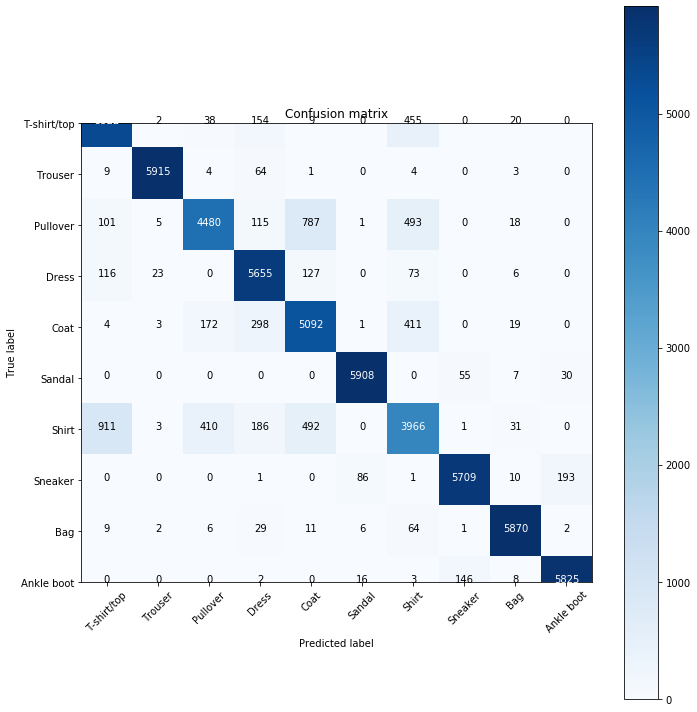

In [48]:
plt.figure(figsize=(10,10))
names = (
    'T-shirt/top'
    ,'Trouser'
    ,'Pullover'
    ,'Dress'
    ,'Coat'
    ,'Sandal'
    ,'Shirt'
    ,'Sneaker'
    ,'Bag'
    ,'Ankle boot'
)
plot_confusion_matrix(cmt, names)
plt.show()

#### calculating loss

In [16]:
network = Network()

In [17]:
preds = network(images)
loss = F.cross_entropy(preds, labels)
loss.item()

2.304056167602539

In [18]:
print(network.conv1.weight.grad)

None


In [19]:
loss.backward()

In [20]:
print(network.conv1.weight.grad.shape)

torch.Size([6, 1, 5, 5])


In [21]:
optimizer = optim.Adam(network.parameters(), lr=0.01)
optimizer.step() # updating weights

In [22]:
network(images).shape

torch.Size([100, 10])

In [23]:
F.softmax(network(images), dim=1).argmax(dim=1)

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [24]:
F.softmax(network(images), dim=1).argmax(dim=1).eq(labels).sum().item()

13